<a href="https://colab.research.google.com/github/SLTH-Project/ThSL-Model/blob/main/Find_Model_SLTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content'

/content


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/All Dataset/Github/Dataset_Original_SLTH_100_Full.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content')
  print('Done')

Done


#Import

In [ ]:
from numpy import expand_dims
import numpy as np

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


import tensorflow
import tensorflow as tf

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from PIL import Image 
from PIL import ImageFilter 

from scipy import ndimage
from skimage.transform import resize

import os
from os import listdir

import cv2
import time
import random

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import BatchNormalization

#Split folder

In [ ]:
!pip install split_folders

In [ ]:
pip install split-folders tqdm

In [ ]:
import splitfolders 

## Train : Validation : Test 

In [ ]:
DATA_PATH = '/content/Dataset_Original_SLTH_100_Full'

Train set : 70%, Test set : 20%, Validation set : 10%

In [ ]:
SAVE_DATA_PATH = '/content/Dataset_Split_Full/'
os.makedirs(SAVE_DATA_PATH)

In [ ]:
splitfolders.ratio(DATA_PATH, output=SAVE_DATA_PATH, seed=1337, ratio=(0.7, 0.1, 0.2)) # (train:val:test)

Copying files: 114000 files [00:15, 7135.14 files/s]


#Load dataset

In [ ]:
SIZE =224 #224,128
CLASS_MODE = 'sparse'  #sparse , categorical
BATCH_SIZE = 128
NUM_CLASS=100
COLOR_MODE ='rgb'
CHANNEL = 3

In [ ]:
root_dir = '/content/'
dataset_dir = os.path.join(root_dir, 'Dataset_Split_Full')
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

Trian

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input ,dtype='float32') #included in our dependencies
train_generator = train_datagen.flow_from_directory(train_dir, # this is where you specify the path to the main data folder
                                                 target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                 )

Found 79800 images belonging to 100 classes.


Test

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
test_generator = test_datagen.flow_from_directory(test_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                 )

Found 22800 images belonging to 100 classes.


In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
val_generator = val_datagen.flow_from_directory(val_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                )

Found 11400 images belonging to 100 classes.


#MobileNetV2

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv2_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 60/100 epoch [40%]  R1

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2_1.h5'
EPOCH = 60
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/60
623/623 [==============================] - 503s 802ms/step - loss: 3.7067 - accuracy: 0.1149 - val_loss: 2.2103 - val_accuracy: 0.4720
Epoch 2/60
623/623 [==============================] - 452s 725ms/step - loss: 2.4433 - accuracy: 0.2848 - val_loss: 1.4361 - val_accuracy: 0.6331
Epoch 3/60
623/623 [==============================] - 358s 574ms/step - loss: 1.9728 - accuracy: 0.3848 - val_loss: 1.1170 - val_accuracy: 0.7021
Epoch 4/60
623/623 [==============================] - 337s 541ms/step - loss: 1.7362 - accuracy: 0.4441 - val_loss: 0.9525 - val_accuracy: 0.7366
Epoch 5/60
623/623 [==============================] - 333s 535ms/step - loss: 1.6022 - accuracy: 0.4839 - val_loss: 0.8538 - val_accuracy: 0.7683
Epoch 6/60
623/623 [==============================] - 375s 601ms/step - loss: 1.5013 - accuracy: 0.5122 - val_loss: 0.7842 - val_accuracy: 0.7741
Epoch 7/60
623/623 [==============================] - 403s 647ms/step - loss: 1.4280 - accuracy: 0.5342 - val_loss: 0.7284 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 35/100 epoch [25%] R2


In [ ]:
from keras.models import load_model
model_MBv2_1 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2_1.h5')

In [ ]:
SAVE_model_MBv2_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2_2.h5'
EPOCH = 35
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_2)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/35
623/623 [==============================] - 398s 634ms/step - loss: 0.7814 - accuracy: 0.7503 - val_loss: 0.2662 - val_accuracy: 0.9225
Epoch 2/35
623/623 [==============================] - 399s 640ms/step - loss: 0.7565 - accuracy: 0.7579 - val_loss: 0.2616 - val_accuracy: 0.9241
Epoch 3/35
623/623 [==============================] - 395s 634ms/step - loss: 0.7351 - accuracy: 0.7616 - val_loss: 0.2569 - val_accuracy: 0.9255
Epoch 4/35
623/623 [==============================] - 397s 637ms/step - loss: 0.7202 - accuracy: 0.7688 - val_loss: 0.2548 - val_accuracy: 0.9253
Epoch 5/35
623/623 [==============================] - 396s 636ms/step - loss: 0.7198 - accuracy: 0.7666 - val_loss: 0.2527 - val_accuracy: 0.9250
Epoch 6/35
623/623 [==============================] - 398s 639ms/step - loss: 0.7152 - accuracy: 0.7695 - val_loss: 0.2512 - val_accuracy: 0.9261
Epoch 7/35
623/623 [==============================] - 399s 640ms/step - loss: 0.7037 - accuracy: 0.7715 - val_loss: 0.2480 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-4| 5/100 epoch [25%] R3

In [ ]:
SAVE_model_MBv2_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2_3.h5'
EPOCH = 5
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_3)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/5
623/623 [==============================] - 374s 595ms/step - loss: 0.6476 - accuracy: 0.7903 - val_loss: 0.2234 - val_accuracy: 0.9327
Epoch 2/5
623/623 [==============================] - 366s 588ms/step - loss: 0.6499 - accuracy: 0.7893 - val_loss: 0.2241 - val_accuracy: 0.9313
Epoch 3/5
623/623 [==============================] - 365s 586ms/step - loss: 0.6514 - accuracy: 0.7899 - val_loss: 0.2228 - val_accuracy: 0.9329
Epoch 4/5
623/623 [==============================] - 362s 581ms/step - loss: 0.6447 - accuracy: 0.7906 - val_loss: 0.2228 - val_accuracy: 0.9321
Epoch 5/5
623/623 [==============================] - 365s 585ms/step - loss: 0.6447 - accuracy: 0.7892 - val_loss: 0.2224 - val_accuracy: 0.9328


In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2_3.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

179/179 [==============================] - 90s 500ms/step - loss: 0.2296 - accuracy: 0.9271
test_acc: 0.9271491169929504
test_loss: 0.22964517772197723


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2//history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2//history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

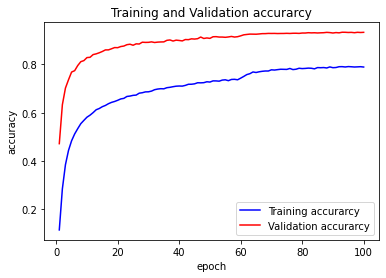

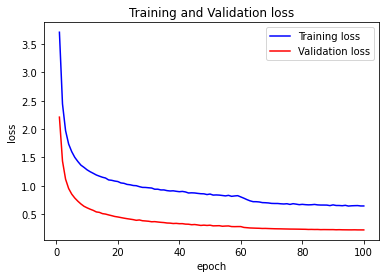

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/model_MBv2.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpjgpnylmj/assets


10363908

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.93      0.93      0.93       228
         airplane       1.00      0.98      0.99       228
            angry       0.99      0.99      0.99       228
           animal       0.94      0.84      0.88       228
              bat       0.98      0.95      0.96       228
             bite       1.00      0.99      1.00       228
     bow the head       1.00      0.99      0.99       228
             bowl       0.96      0.95      0.95       228
            bread       0.93      0.92      0.92       228
          buffalo       0.97      0.99      0.98       228
             care       0.99      0.99      0.99       228
              cat       1.00      0.96      0.98       228
            chest       0.95      0.99      0.97       228
           cockle       0.99      0.98      0.98       228
            cough       0.96      1.00      0.98       228
              cow       0.98      0.98      0.98       

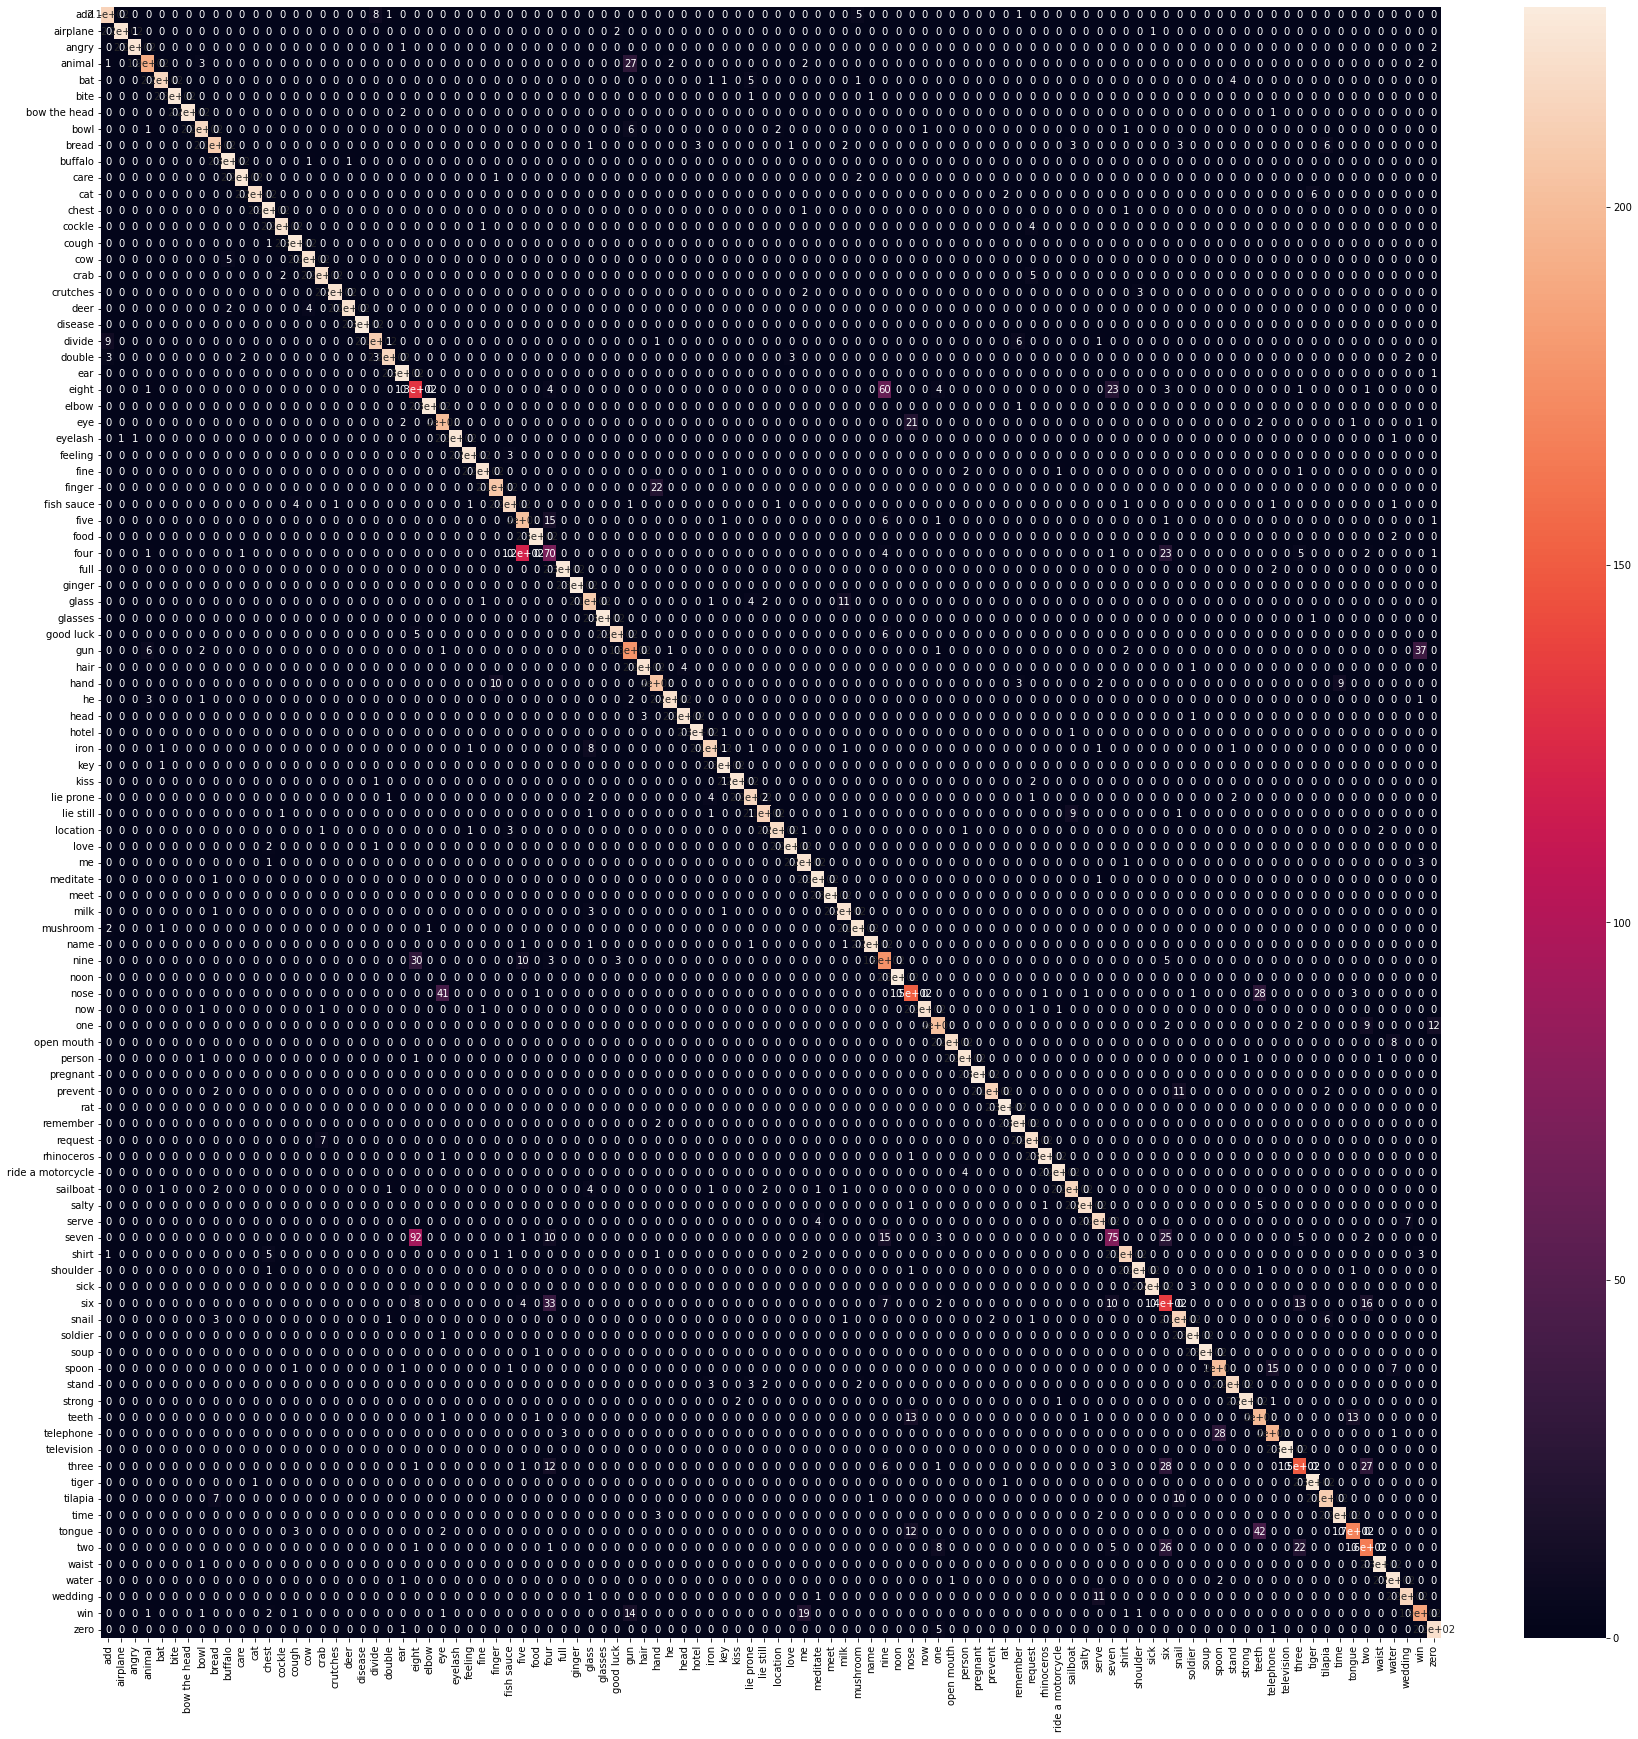

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#MobileNetV2 without dropout layer

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  #x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  #x = Dropout(0.5)(x)
  #x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  #x = Dropout(0.5)(x)
  #x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  #x = Dropout(0.5)(x)
  #x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv2_2= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 60/100 epoch [40%]  R1

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2_wo_dropout/model_MBv2_1.h5'
EPOCH = 50
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv2_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/50
623/623 [==============================] - 654s 1s/step - loss: 1.8413 - accuracy: 0.4894 - val_loss: 0.9270 - val_accuracy: 0.7032
Epoch 2/50
623/623 [==============================] - 468s 751ms/step - loss: 0.6808 - accuracy: 0.7790 - val_loss: 0.5432 - val_accuracy: 0.8209
Epoch 3/50
623/623 [==============================] - 350s 561ms/step - loss: 0.4438 - accuracy: 0.8527 - val_loss: 0.4214 - val_accuracy: 0.8590
Epoch 4/50
623/623 [==============================] - 346s 555ms/step - loss: 0.3324 - accuracy: 0.8887 - val_loss: 0.3441 - val_accuracy: 0.8838
Epoch 5/50
623/623 [==============================] - 364s 585ms/step - loss: 0.2565 - accuracy: 0.9122 - val_loss: 0.3381 - val_accuracy: 0.8848
Epoch 6/50
623/623 [==============================] - 391s 627ms/step - loss: 0.2101 - accuracy: 0.9281 - val_loss: 0.2801 - val_accuracy: 0.9027
Epoch 7/50
623/623 [==============================] - 362s 581ms/step - loss: 0.1694 - accuracy: 0.9421 - val_loss: 0.2815 - va

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2_wo_dropout/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2_wo_dropout/model_MBv2_1.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

179/179 [==============================] - 91s 505ms/step - loss: 0.2419 - accuracy: 0.9492
test_acc: 0.9491666555404663
test_loss: 0.2419457733631134


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2_wo_dropout/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

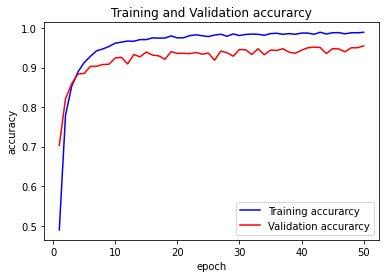

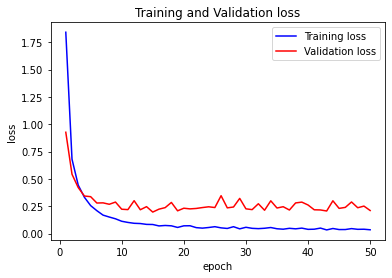

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

#MobileNetV3Small

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

4349952/4334752 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv3S_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 60/100 epoch [40%]  R1

In [ ]:
SAVE_model_MBv3S_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/model_MBv3S_1.h5'
EPOCH = 60
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_1)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/60
623/623 [==============================] - 269s 425ms/step - loss: 4.3569 - accuracy: 0.0367 - val_loss: 3.8555 - val_accuracy: 0.1016
Epoch 2/60
623/623 [==============================] - 235s 376ms/step - loss: 3.5514 - accuracy: 0.0937 - val_loss: 2.9068 - val_accuracy: 0.2258
Epoch 3/60
623/623 [==============================] - 235s 377ms/step - loss: 3.1546 - accuracy: 0.1429 - val_loss: 2.5199 - val_accuracy: 0.2937
Epoch 4/60
623/623 [==============================] - 227s 364ms/step - loss: 2.9281 - accuracy: 0.1772 - val_loss: 2.3727 - val_accuracy: 0.3137
Epoch 5/60
623/623 [==============================] - 228s 366ms/step - loss: 2.7874 - accuracy: 0.1997 - val_loss: 2.2123 - val_accuracy: 0.3537
Epoch 6/60
623/623 [==============================] - 234s 376ms/step - loss: 2.6825 - accuracy: 0.2170 - val_loss: 2.0934 - val_accuracy: 0.3885
Epoch 7/60
623/623 [==============================] - 235s 378ms/step - loss: 2.6020 - accuracy: 0.2357 - val_loss: 2.0046 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 35/100 epoch [25%] R2


In [ ]:
SAVE_model_MBv3S_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/model_MBv3S_2.h5'
EPOCH = 35
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_2)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/35
623/623 [==============================] - 246s 388ms/step - loss: 1.8126 - accuracy: 0.4253 - val_loss: 1.1642 - val_accuracy: 0.6532
Epoch 2/35
623/623 [==============================] - 242s 389ms/step - loss: 1.7654 - accuracy: 0.4376 - val_loss: 1.1451 - val_accuracy: 0.6571
Epoch 3/35
623/623 [==============================] - 233s 374ms/step - loss: 1.7566 - accuracy: 0.4372 - val_loss: 1.1371 - val_accuracy: 0.6611
Epoch 4/35
623/623 [==============================] - 234s 376ms/step - loss: 1.7486 - accuracy: 0.4395 - val_loss: 1.1292 - val_accuracy: 0.6632
Epoch 5/35
623/623 [==============================] - 235s 377ms/step - loss: 1.7371 - accuracy: 0.4413 - val_loss: 1.1253 - val_accuracy: 0.6628
Epoch 6/35
623/623 [==============================] - 243s 390ms/step - loss: 1.7256 - accuracy: 0.4448 - val_loss: 1.1214 - val_accuracy: 0.6642
Epoch 7/35
623/623 [==============================] - 235s 378ms/step - loss: 1.7245 - accuracy: 0.4469 - val_loss: 1.1143 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-4| 5/100 epoch [25%] R3

In [ ]:
SAVE_model_MBv3S_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/model_MBv3S_3.h5'
EPOCH = 5
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_3)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/5
623/623 [==============================] - 288s 456ms/step - loss: 1.6641 - accuracy: 0.4637 - val_loss: 1.0629 - val_accuracy: 0.6775
Epoch 2/5
623/623 [==============================] - 240s 385ms/step - loss: 1.6553 - accuracy: 0.4657 - val_loss: 1.0632 - val_accuracy: 0.6785
Epoch 3/5
623/623 [==============================] - 237s 380ms/step - loss: 1.6597 - accuracy: 0.4659 - val_loss: 1.0580 - val_accuracy: 0.6792
Epoch 4/5
623/623 [==============================] - 234s 376ms/step - loss: 1.6606 - accuracy: 0.4620 - val_loss: 1.0613 - val_accuracy: 0.6794
Epoch 5/5
623/623 [==============================] - 235s 377ms/step - loss: 1.6573 - accuracy: 0.4651 - val_loss: 1.0593 - val_accuracy: 0.6790


In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/model_MBv3S_3.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

179/179 [==============================] - 76s 417ms/step - loss: 1.0546 - accuracy: 0.6820
test_acc: 0.6819736957550049
test_loss: 1.0545885562896729


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

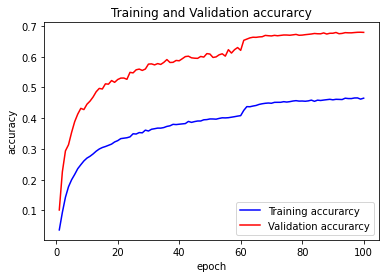

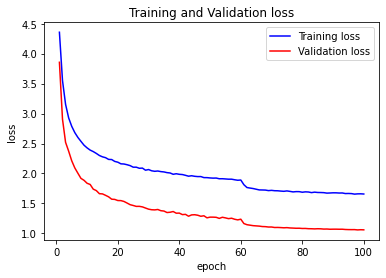

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/model_MBv3S.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp39adom5e/assets


4513972

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.51      0.39      0.44       228
         airplane       0.96      0.86      0.91       228
            angry       0.83      0.78      0.80       228
           animal       0.53      0.37      0.43       228
              bat       0.74      0.83      0.78       228
             bite       0.97      0.93      0.95       228
     bow the head       0.83      0.96      0.89       228
             bowl       0.54      0.65      0.59       228
            bread       0.70      0.50      0.58       228
          buffalo       0.78      0.89      0.83       228
             care       0.78      0.63      0.70       228
              cat       0.70      0.63      0.66       228
            chest       0.75      0.84      0.79       228
           cockle       0.75      0.86      0.80       228
            cough       0.76      0.72      0.74       228
              cow       0.67      0.81      0.73       

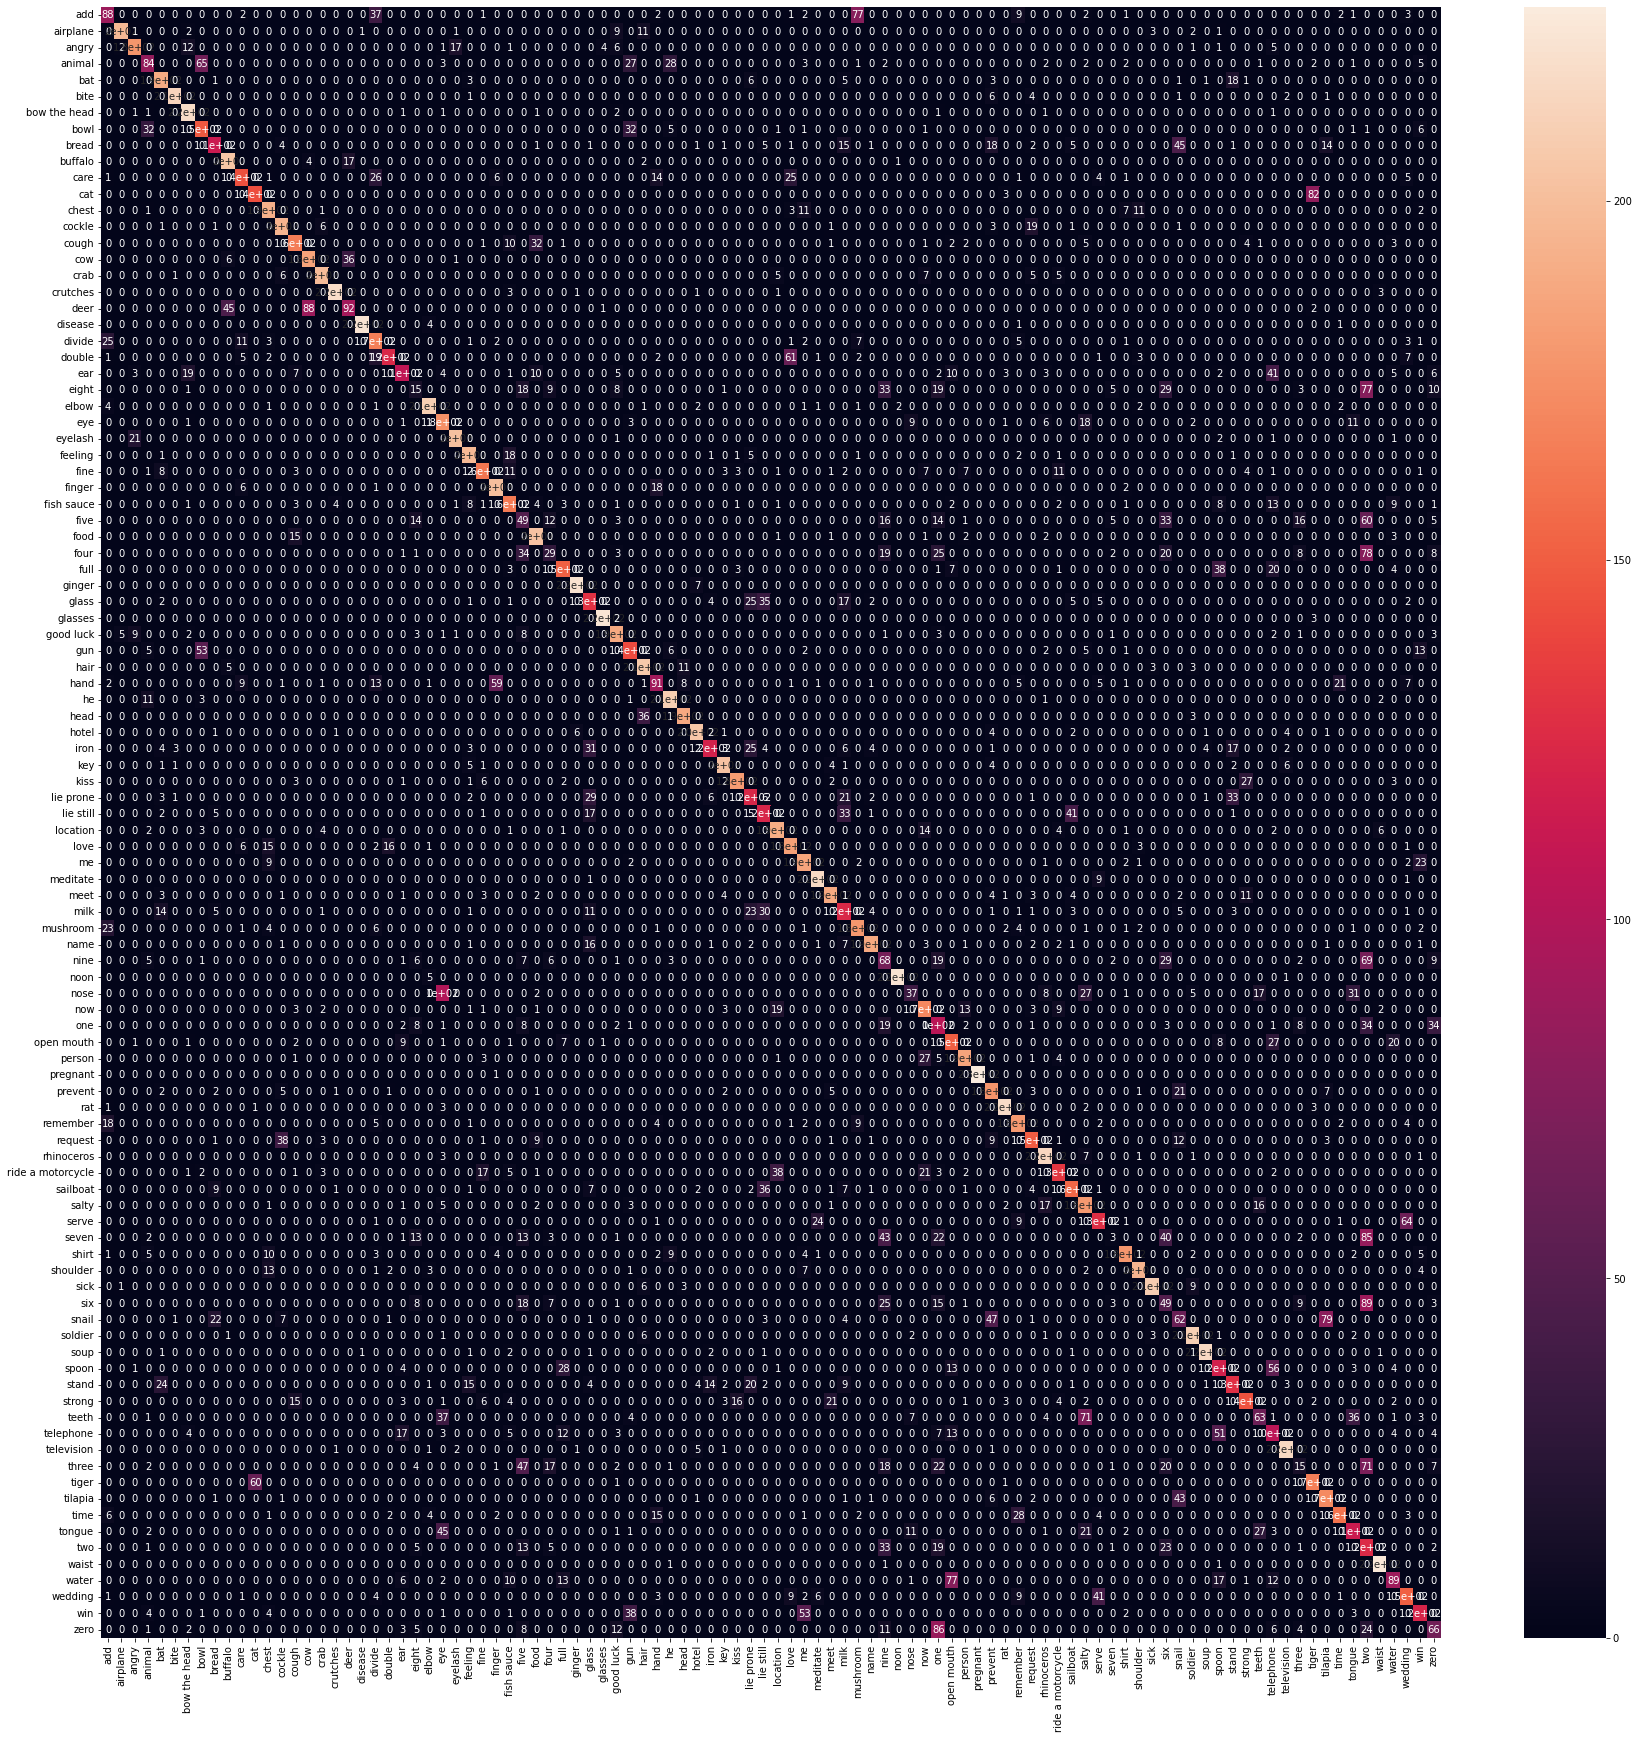

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#MobileNetV3Large

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv3L_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 60/100 epoch [40%]  R1

In [ ]:
SAVE_model_MBv3L_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/model_MBv3L_1.h5'
EPOCH = 60
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_1)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/60
623/623 [==============================] - 395s 627ms/step - loss: 4.3797 - accuracy: 0.0410 - val_loss: 3.7149 - val_accuracy: 0.1587
Epoch 2/60
623/623 [==============================] - 355s 570ms/step - loss: 3.5062 - accuracy: 0.1073 - val_loss: 2.8083 - val_accuracy: 0.2588
Epoch 3/60
623/623 [==============================] - 352s 565ms/step - loss: 3.0772 - accuracy: 0.1589 - val_loss: 2.4335 - val_accuracy: 0.3356
Epoch 4/60
623/623 [==============================] - 352s 564ms/step - loss: 2.8385 - accuracy: 0.1936 - val_loss: 2.1730 - val_accuracy: 0.3824
Epoch 5/60
623/623 [==============================] - 351s 564ms/step - loss: 2.6835 - accuracy: 0.2276 - val_loss: 2.0499 - val_accuracy: 0.4185
Epoch 6/60
623/623 [==============================] - 353s 567ms/step - loss: 2.5678 - accuracy: 0.2481 - val_loss: 1.9400 - val_accuracy: 0.4420
Epoch 7/60
623/623 [==============================] - 354s 568ms/step - loss: 2.4717 - accuracy: 0.2706 - val_loss: 1.8697 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 35/100 epoch [25%] R2


In [ ]:
SAVE_model_MBv3L_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/model_MBv3L_2.h5'
EPOCH = 35
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_2)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/35
623/623 [==============================] - 349s 554ms/step - loss: 1.6987 - accuracy: 0.4628 - val_loss: 1.0700 - val_accuracy: 0.6852
Epoch 2/35
623/623 [==============================] - 347s 556ms/step - loss: 1.6664 - accuracy: 0.4723 - val_loss: 1.0619 - val_accuracy: 0.6889
Epoch 3/35
623/623 [==============================] - 342s 549ms/step - loss: 1.6434 - accuracy: 0.4789 - val_loss: 1.0542 - val_accuracy: 0.6909
Epoch 4/35
623/623 [==============================] - 344s 552ms/step - loss: 1.6399 - accuracy: 0.4807 - val_loss: 1.0451 - val_accuracy: 0.6958
Epoch 5/35
623/623 [==============================] - 343s 550ms/step - loss: 1.6349 - accuracy: 0.4804 - val_loss: 1.0372 - val_accuracy: 0.6954
Epoch 6/35
623/623 [==============================] - 343s 550ms/step - loss: 1.6269 - accuracy: 0.4826 - val_loss: 1.0383 - val_accuracy: 0.6938
Epoch 7/35
623/623 [==============================] - 343s 551ms/step - loss: 1.6180 - accuracy: 0.4843 - val_loss: 1.0364 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-4| 5/100 epoch [25%] R3

In [ ]:
SAVE_model_MBv3L_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/model_MBv3L_3.h5'
EPOCH = 5
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_3)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/5
623/623 [==============================] - 345s 547ms/step - loss: 1.5544 - accuracy: 0.5029 - val_loss: 0.9895 - val_accuracy: 0.7074
Epoch 2/5
623/623 [==============================] - 341s 547ms/step - loss: 1.5490 - accuracy: 0.5032 - val_loss: 0.9887 - val_accuracy: 0.7086
Epoch 3/5
623/623 [==============================] - 341s 547ms/step - loss: 1.5510 - accuracy: 0.5039 - val_loss: 0.9875 - val_accuracy: 0.7089
Epoch 4/5
623/623 [==============================] - 343s 551ms/step - loss: 1.5564 - accuracy: 0.5041 - val_loss: 0.9870 - val_accuracy: 0.7080
Epoch 5/5
623/623 [==============================] - 349s 560ms/step - loss: 1.5524 - accuracy: 0.5039 - val_loss: 0.9889 - val_accuracy: 0.7094


In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/model_MBv3L_3.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

179/179 [==============================] - 88s 483ms/step - loss: 0.9790 - accuracy: 0.7136
test_acc: 0.7136403322219849
test_loss: 0.9790318608283997


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

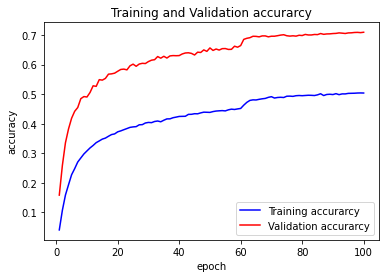

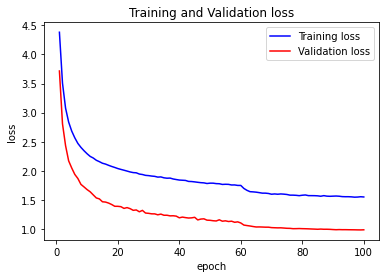

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/model_MBv3L.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpslth2y25/assets


13069124

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.53      0.48      0.50       228
         airplane       0.92      0.90      0.91       228
            angry       0.76      0.72      0.74       228
           animal       0.42      0.52      0.47       228
              bat       0.82      0.86      0.84       228
             bite       0.85      0.85      0.85       228
     bow the head       0.96      0.96      0.96       228
             bowl       0.70      0.60      0.64       228
            bread       0.61      0.28      0.38       228
          buffalo       0.91      0.88      0.89       228
             care       0.82      0.84      0.83       228
              cat       0.74      0.57      0.65       228
            chest       0.84      0.76      0.80       228
           cockle       0.58      0.65      0.61       228
            cough       0.90      0.91      0.91       228
              cow       0.69      0.87      0.77       

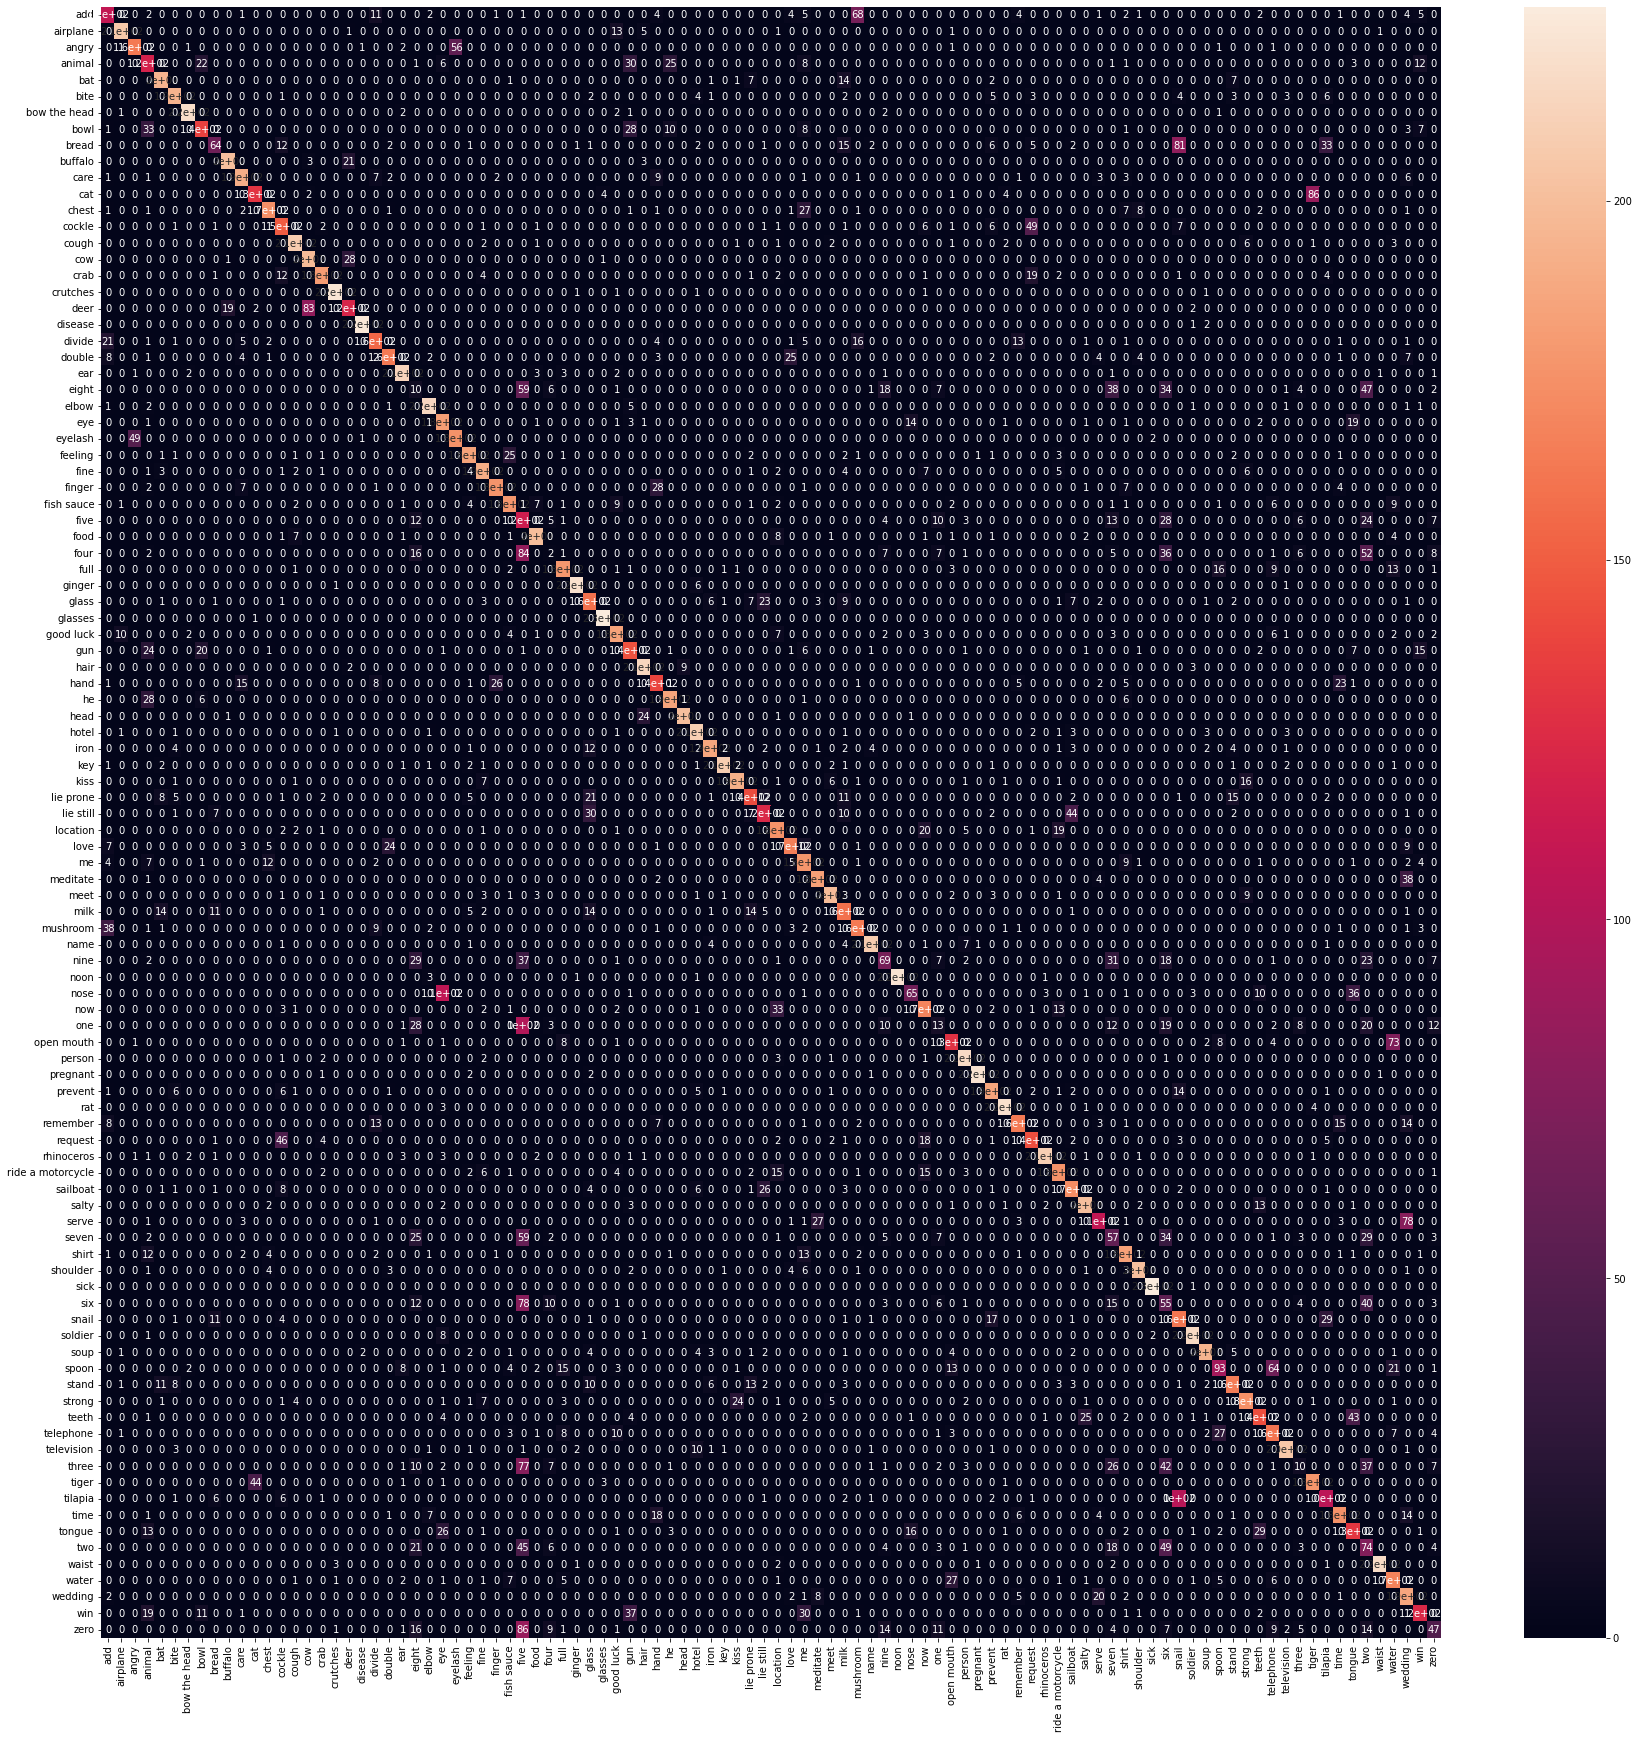

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#Recap graph 

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

Path_1 = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Large/history.csv'
with open(Path_1, 'rb') as handle:
    his_MBLarge = load(handle)

Path_2 = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV3Small/history.csv'
with open(Path_2 , 'rb') as handle:
    his_MBSmall = load(handle)

Path_3 = '/content/drive/MyDrive/All Dataset/Github/Find_Model_SLTH/MobileNetV2/history.csv'
with open(Path_3, 'rb') as handle:
    his_MBv2 = load(handle)



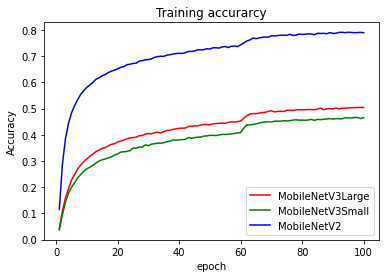

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Accuracy
acc1 = his_MBLarge['accuracy']
acc2 = his_MBSmall['accuracy']
acc3 = his_MBv2['accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Training accurarcy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()


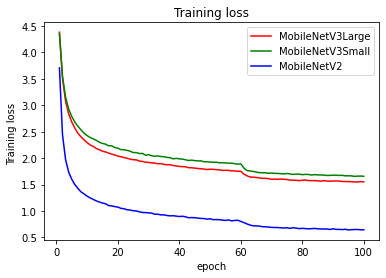

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Loss
acc1 = his_MBLarge['loss']
acc2 = his_MBSmall['loss']
acc3 = his_MBv2['loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Training loss')
plt.ylabel('Training loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

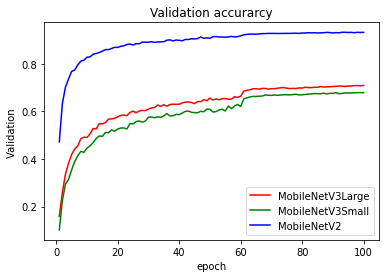

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Accuracy
acc1 = his_MBLarge['val_accuracy']
acc2 = his_MBSmall['val_accuracy']
acc3 = his_MBv2['val_accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Validation accurarcy')
plt.ylabel('Validation ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

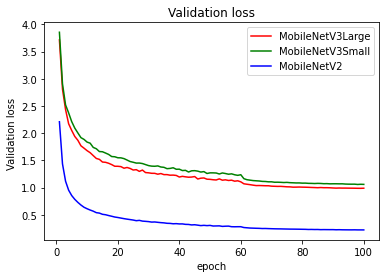

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Loss
acc1 = his_MBLarge['val_loss']
acc2 = his_MBSmall['val_loss']
acc3 = his_MBv2['val_loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Validation loss')
plt.ylabel('Validation loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

#4 Layer (2CL, 2FC) 16 filter | 20 epochs -> Best Model of India

In [ ]:
img_rows, img_cols = 128,128
input_shape = (img_rows, img_cols, 3) #Grey 1, RGB 3
num_classes = 100

indian_model = Sequential()
#1. CNN LAYER
indian_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding = 'Same',activation='relu',input_shape=input_shape))

#2. CNN LAYER
indian_model.add(Conv2D(16, (3, 3) , activation='relu'))
indian_model.add(MaxPooling2D(pool_size=(2, 2)))

indian_model.add(Dropout(0.5))

#FULLY CONNECTED LAYER
indian_model.add(Flatten())
indian_model.add(Dense(64, activation='relu'))

#OUTPUT LAYER
indian_model.add(Dense(num_classes, activation='softmax'))
indian_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 64)                4064320   
                                                        

In [ ]:
indian_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history= indian_model.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = 20,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL
                   )

Epoch 1/20
623/623 [==============================] - 223s 356ms/step - loss: 4.5267 - accuracy: 0.0265 - val_loss: 4.2824 - val_accuracy: 0.0646
Epoch 2/20
623/623 [==============================] - 217s 348ms/step - loss: 3.8008 - accuracy: 0.1207 - val_loss: 3.1817 - val_accuracy: 0.2066
Epoch 3/20
623/623 [==============================] - 219s 351ms/step - loss: 2.8915 - accuracy: 0.2577 - val_loss: 2.5360 - val_accuracy: 0.3243
Epoch 4/20
623/623 [==============================] - 218s 350ms/step - loss: 2.3101 - accuracy: 0.3712 - val_loss: 2.0420 - val_accuracy: 0.4328
Epoch 5/20
623/623 [==============================] - 223s 358ms/step - loss: 1.8565 - accuracy: 0.4729 - val_loss: 1.6137 - val_accuracy: 0.5345
Epoch 6/20
623/623 [==============================] - 220s 352ms/step - loss: 1.5124 - accuracy: 0.5578 - val_loss: 1.3546 - val_accuracy: 0.5995
Epoch 7/20
623/623 [==============================] - 229s 368ms/step - loss: 1.2643 - accuracy: 0.6227 - val_loss: 1.1114 -

In [ ]:
test_loss, test_acc=indian_model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

179/179 [==============================] - 29s 161ms/step - loss: 0.4449 - accuracy: 0.8629
test_acc: 0.8628947138786316
test_loss: 0.4449400007724762


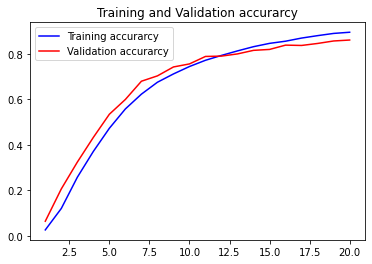

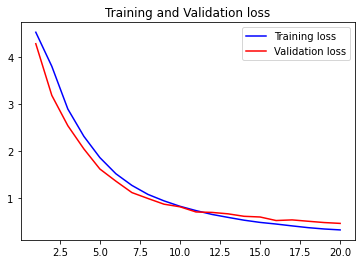

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()